# Wildlife image classification

This notebook implements a CNN, using transfer learning (Xception architecture) to classify 14 classes of animals in the wild, based on Kaggle competition dataset: https://www.kaggle.com/c/iwildcam-2019-fgvc6/data

The notebook uses DLHelper API (https://github.com/LukasNorbutas/DLHelper) to tidy up and resize raw input images, build a train-validation-test split and train neural net models. Several features available in the API:
- Resize images in the train directory to decrease train time
- Build a train/test split using augmentation/downsampling/upsampling
- Resize/reaugment train images on the go (during training/between epochs/etc)
- Learning rate tools: find optimal learning rate using find_lr, discriminative learning rates (Adam), one-cycle-learning


# 0.1 GET DATA

Download source train/test images and csv's from Kaggle

In [2]:
keys = eval(open('kaggle.json', 'r').read())

import os
os.environ['KAGGLE_USERNAME'] = keys["username"]  
os.environ['KAGGLE_KEY'] = keys["key"]
!kaggle competitions download -c iwildcam-2019-fgvc6 --force

  0% 0.00/1.82M [00:00<?, ?B/s]
100% 1.82M/1.82M [00:00<00:00, 59.3MB/s]
100% 4.95M/4.95M [00:00<00:00, 48.3MB/s]

100% 17.4G/17.4G [02:13<00:00, 101MB/s]
100% 17.4G/17.4G [02:13<00:00, 140MB/s]
100% 26.0G/26.0G [03:37<00:00, 177MB/s]
100% 26.0G/26.0G [03:37<00:00, 128MB/s]
  0% 0.00/1.03M [00:00<?, ?B/s]
100% 1.03M/1.03M [00:00<00:00, 148MB/s]


# 0.2 IMPORTS AND PATHS
Import DLHelper module and install tf-gpu 2.0

In [0]:
!mkdir DLHelper
!mkdir DLHelper/image
!mkdir DLHelper/image/utils

In [0]:
!pip install tensorflow-gpu

import tensorflow as tf
from DLHelper.imports import *
from DLHelper.image import *

In [0]:
# DATA_DIR contains train/test data, will contain architectures/weights
DATA_DIR = Path('data/wildcam')
TEMP_DIR = Path('temp/wildcam')

DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
!unzip -q test_images.zip -d {DATA_DIR}/'test'
!unzip -q train_images.zip -d {DATA_DIR}/'train'
!unzip -q train.csv.zip -d {DATA_DIR}

In [6]:
!ls {DATA_DIR}/'train' | head -5

5858bf1e-23d2-11e8-a6a3-ec086b02610b.jpg
5858bf20-23d2-11e8-a6a3-ec086b02610b.jpg
5858bf22-23d2-11e8-a6a3-ec086b02610b.jpg
5858bf23-23d2-11e8-a6a3-ec086b02610b.jpg
5858bf24-23d2-11e8-a6a3-ec086b02610b.jpg


In [7]:
!cat {DATA_DIR}/train.csv | head -5

category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747


# 1. CLEAN/EXPLORE RAW DATA

DataRaw class creates an object that contains a cleaned up dataframe with paths to train images. I relabel all classes to 0-13 in order to not confuse the neural net's output layer (N=14). The original data contains 20+ classes, but some of them are missing in the data. We will skip those classes in this model.

In [0]:
# Initialize a DataRaw instance using train data, create a DF with img ids and labels
# based on the available train.csv file
wild_data_raw = DataRaw(DATA_DIR, filetype="jpg")
wild_data_raw.init_df(dataframe_path=DATA_DIR/"train.csv", label_col="category_id", 
                      id_col="file_name")

In [0]:
wild_data_raw.df.label = wild_data_raw.df.label.map(lambda x: str(x))

In [0]:
label_map = {
    0: '0',
    1: '1',
    2: '3',
    3: '4',
    4: '8',
    5: '10',
    6: '11',
    7: '13',
    8: '14',
    9: '16',
    10: '17',
    11: '18',
    12: '19',
    13: '22'
}

In [0]:
wild_data_raw.label_encode(label_map=label_map, one_hot=False)

The data contain 196299 examples of 14 categories. The highest/lowest category counts are 
'0': 131457 and '22': 33


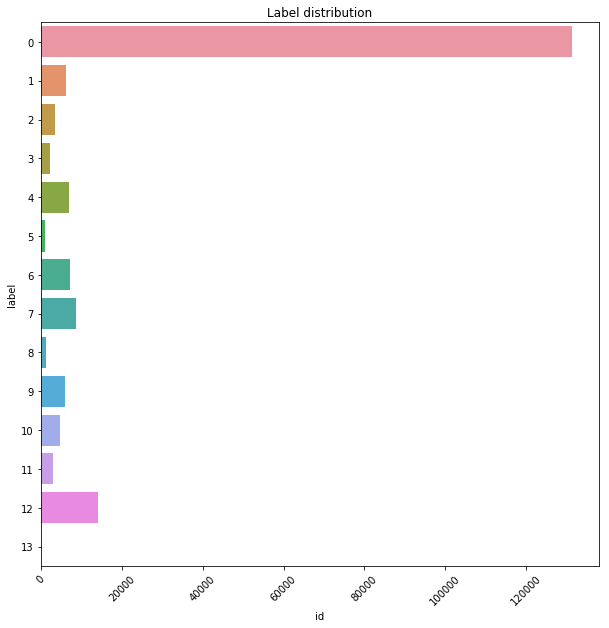

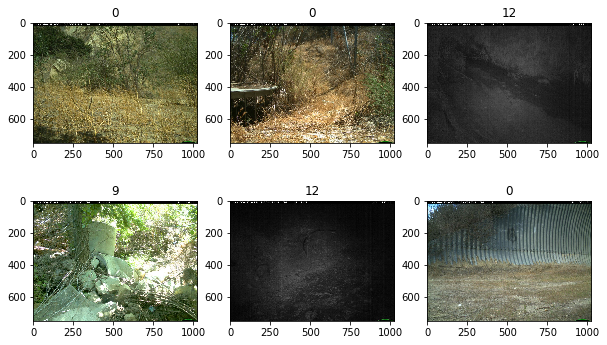

In [12]:
wild_data_raw.describe() 

## Resize input images 

Image files in "DATA_DIR/train" are resized to 0.5 of their original size, since they are all large. This will increase training speed substantially. H/t to Martynas for the idea.

In [18]:
wild_data_raw.rescale_input_images("train_old", DATA_DIR, scale_size=0.35)
!du {DATA_DIR}

27791108	data/wildcam/train_old
10190384	data/wildcam/train
18626268	data/wildcam/test
56639780	data/wildcam


## Use 33% of the train dataset for experimentation

To speed initial experimentation, 1/3rd of all the training data is used. The final model will be built on all available data.

In [19]:
wild_data_raw.df = wild_data_raw.df.sample(frac=0.33)
print(f"Classes left: {len(wild_data_raw.df.label.unique())} / 14",
     f"Smallest class has {wild_data_raw.df.label.value_counts().iloc[-1]} cases")

Classes left: 14 / 14 Smallest class has 15 cases


# 2. Baseline model: no sampling/augmentation/weights

DataSplit class splits the DataRaw data into train/val/test, stores relevant properties, supports augmentation, up/downsampling/etc. Uses tf.data.Dataset, i.e. creates a dataset generator. It can later be passed to CNNLearner neural net class. 

In [0]:
# Create a DataSplit (train/val/test)
wild_data_split = DataSplit(wild_data_raw, 
                        val_test_size=(0.15,0.1), 
                        batch_size=16, 
                        train_shuffle=True, 
                        prefetch=1, 
                        num_parallel_calls=-1, 
                        aug=None,
                        downsample=None,
                      upsample=0)

In [21]:
# Create baseline model
model_baseline = CNNLearner(name="xception_1", 
                    path=str(DATA_DIR), 
                    data=wild_data_split, 
                    base_model=keras.applications.Xception,
                    input_shape=(100,100,3), 
                    output_layer=keras.layers.Dense(
                        14,
                        kernel_regularizer=keras.regularizers.l1_l2(1e-6, 1e-4),
                        activation=keras.activations.softmax,
                    ), 
                    dropout=0.5, 
                    load=None)

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
model_baseline.compile(optimizer=keras.optimizers.Adam,
              lr=1e-4,
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [0]:
# Freeze all but final layers and resize the images to 100x100
wild_data_split.resize(img_dims=(100,100,3), resize="stretch")
model_baseline.freeze(3)

All but 3 layers frozen. Compilation arguments not provided model recompiled with previous settings.


In [0]:
# Find optimal learning rate
model_baseline.find_lr()

Train for 3037 steps
2623/3037 [========================>.....] - ETA: 37s - loss: 3.2280 - sparse_categorical_accuracy: 0.2903

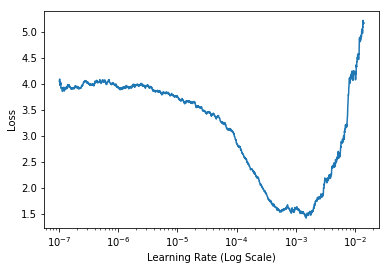

In [0]:
model_baseline.plot_lr()

In [0]:
# Fit the frozen model
model_baseline.fit(1, lr=1e-4, name="m1_baseline_frozen_100")

Train for 3037 steps, validate for 608 steps
3037/3037 [==============================] - 324s 107ms/step - loss: 1.6007 - sparse_categorical_accuracy: 0.5847 - val_loss: 1.4262 - val_sparse_categorical_accuracy: 0.6813
Note: m1_baseline_frozen_100 are loaded.


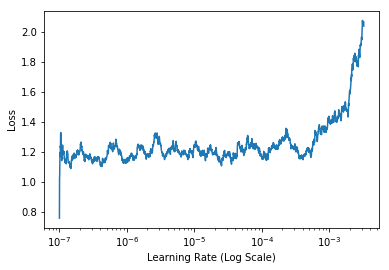

In [0]:
# Unfreeze the model, find learning rates again
model_baseline.unfreeze()
model_baseline.find_lr()
model_baseline.plot_lr(skip_begin=0, skip_end=100)

In [0]:
# Train the unfrozen networks with one-cycle learning, using minimum LR of 5e-5,
# and max LR of 2e-4.
model_baseline.fit_one_cycle(lr=(5e-5, 2e-4), name="m1_baseline_unfrozen_100",
                            epochs=3)

Note: Discriminative learning rates are disabled, but tuple lr is passed. Use dlr=True for DLR optimizer.
Train for 3037 steps, validate for 608 steps
Epoch 1/3
3037/3037 [==============================] - 318s 105ms/step - loss: 1.1414 - sparse_categorical_accuracy: 0.6941 - val_loss: 1.4546 - val_sparse_categorical_accuracy: 0.6804
Epoch 2/3
3037/3037 [==============================] - 297s 98ms/step - loss: 1.0601 - sparse_categorical_accuracy: 0.7087 - val_loss: 1.4742 - val_sparse_categorical_accuracy: 0.6801
Epoch 3/3
3037/3037 [==============================] - 299s 99ms/step - loss: 1.0184 - sparse_categorical_accuracy: 0.7179 - val_loss: 1.3692 - val_sparse_categorical_accuracy: 0.6826
Note: m1_baseline_unfrozen_100 are loaded.


In [0]:
m1_baseline_f1 = model_baseline.acc_report()["macro avg"]["f1-score"]
print(f"------------------------------\nMODEL 1 BASELINE SCORE (UNWEIGHTED F1): {round(m1_baseline_f1, 5)}",
      "\n------------------------------")

------------------------------
MODEL 1 BASELINE SCORE (UNWEIGHTED F1): 0.10481 
------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 3. Downsampling the "empty" category

The largest label class "empty" contains images taken repeatedly in specific locations at specific times. Many of them are almost identical.

*DOWNSAMPLING STRATEGY*: downsample based on location and time (of day and year). I.e., remove images of class "empty" taken at the same location+hour of the day multiple times, or location+month multiple times.

In [0]:
# One image has invalid date value (11 11)
wild_data_split.train_dataframe.sort_values(by="date_captured").head(3)
wild_data_split.train_dataframe = wild_data_split.train_dataframe.drop(100372)

In [0]:
pd.set_option('mode.chained_assignment', None)

# Extract month of year and hour of day from date_captured
wild_data_split.train_dataframe.date_captured = wild_data_split.train_dataframe.date_captured.astype('datetime64[ns]')
wild_data_split.train_dataframe["time_captured"] = wild_data_split.train_dataframe.date_captured.dt.hour
wild_data_split.train_dataframe["month_captured"] = wild_data_split.train_dataframe.date_captured.dt.month
wild_data_split.train_dataframe.time_captured.value_counts().head(10)

12    5972
13    4628
14    4108
11    3231
15    2344
3     1912
1     1904
4     1823
2     1755
10    1744
Name: time_captured, dtype: int64

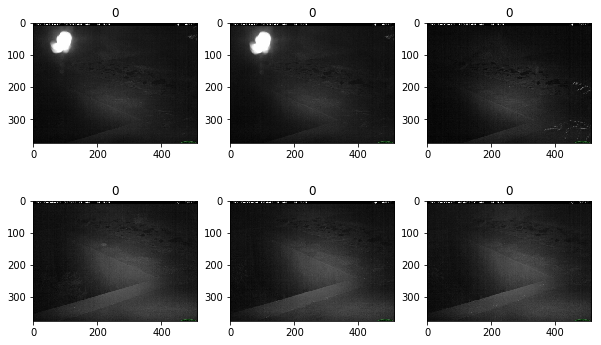

In [0]:
# Plot several images that were taken at the same location at a 
# similar time of the day
dfslice = wild_data_split.train_dataframe.loc[(wild_data_split.train_dataframe["label"] == 0) & 
                               (wild_data_split.train_dataframe["location"] == 24) & 
                              (wild_data_split.train_dataframe["time_captured"].between(0,6))]
wild_data_raw.show_images(dfslice, n_img = 6)

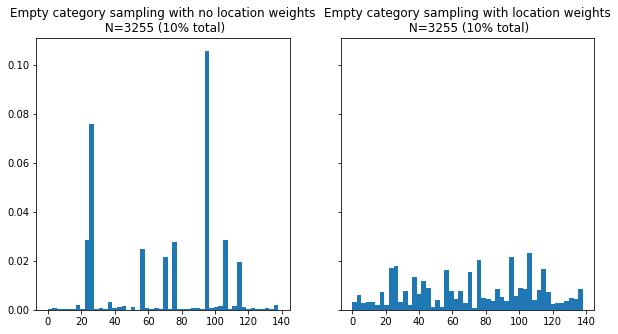

In [0]:
# Create weights
sampling_df = wild_data_split.train_dataframe.loc[wild_data_split.train_dataframe.label == 0, :].copy()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax[0].hist(x=sampling_df.sample(frac=0.15).location, bins=50, density=True)
ax[0].set_title(f"Empty category sampling with no location weights\n N={round(len(sampling_df)*0.10)} (10% total)")

# Groupby month and time of the photo. Calculate counts of images for each group.
location_month_time_counts = sampling_df.groupby(["location", "month_captured",
                                        "time_captured"]).label.count().reset_index()
location_month_time_counts.columns = ["location", "month_captured", "time_captured", "count"]

# Get the total number of photos for each location/month.
location_month_counts = sampling_df.groupby(["location", "month_captured"]).label.count().reset_index()
location_month_counts.columns = ["location", "month_captured", "count_total"]

# Merge the two groupby dataframes
total_weight = pd.merge(location_month_time_counts, location_month_counts, on=["location", "month_captured"])
total_weight["total_N"] = len(sampling_df)

# Calculate weights: weight is lower for images that were taken at a similar time/month/location,
# Weight is higher for images that are unique (e.g. 1 shot taken in May, Location 3)
total_weight["weight"] = (1/total_weight["count"]) + (1/(total_weight["count_total"]/total_weight.total_N))

total_weight.weight = total_weight.weight + abs(min(total_weight.weight))

# Merge weights
sampling_df = pd.merge(sampling_df, total_weight[["location", "month_captured", "time_captured", "weight"]],
                  on=["location", "month_captured", "time_captured"])

# Sample based on weights
sampled_df = sampling_df.sample(frac=0.10, weights="weight", replace=False)

# Display distribution comparison
ax[1].hist(x=sampled_df.location, bins=50, density=True)
ax[1].set_title(f"Empty category sampling with location weights\n N={len(sampled_df)} (10% total)")
plt.show()

In [0]:
# Delete cases with label 0 in the train dataframe
wild_data_split.train_dataframe = wild_data_split.train_dataframe.loc[
    wild_data_split.train_dataframe.label != 0, :]
# Replace it with the newly downsampled cases
wild_data_split.train_dataframe = wild_data_split.train_dataframe.append(sampled_df)
# Reshuffle
wild_data_split.train_dataframe = wild_data_split.train_dataframe.sample(frac=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [0]:
wild_data_split.train_dataframe.label.value_counts(normalize=True)

12    0.180579
0     0.168758
7     0.109394
6     0.094100
4     0.089175
1     0.078598
9     0.075332
10    0.062733
2     0.042928
11    0.038470
3     0.028411
8     0.017679
5     0.013376
13    0.000467
Name: label, dtype: float64

In [0]:
# Resize the downsampled train set and re-initiate the neural net
wild_data_split.resize(img_dims=(100,100,3), resize="stretch")

model_downsampled = CNNLearner(name="xception_2", 
                    path=str(DATA_DIR), 
                    data=wild_data_split, 
                    base_model=keras.applications.Xception,
                    input_shape=(100,100,3), 
                    output_layer=keras.layers.Dense(
                        14,
                        kernel_regularizer=keras.regularizers.l1_l2(1e-7, 3e-4),
                        activation=keras.activations.softmax,
                    ), 
                    dropout=0.45, 
                    load=None)

model_downsampled.compile(optimizer=keras.optimizers.Adam,
              lr=1e-4,
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [0]:
model_downsampled.freeze(3)
model_downsampled.fit(1, lr=1e-4, name="m2_downsampled_frozen_100")

All but 3 layers frozen. Compilation arguments not provided model recompiled with previous settings.
Train for 1213 steps, validate for 608 steps
1213/1213 [==============================] - 158s 131ms/step - loss: 2.8863 - sparse_categorical_accuracy: 0.2282 - val_loss: 1.8481 - val_sparse_categorical_accuracy: 0.4020
Note: m2_downsampled_frozen_100 are loaded.


In [0]:
model_downsampled.unfreeze()
model_downsampled.fit_one_cycle(lr=(5e-5, 2e-4), name="m2_downsampled_unfrozen_100",
                            epochs=8)

Note: Discriminative learning rates are disabled, but tuple lr is passed. Use dlr=True for DLR optimizer.
Train for 1207 steps, validate for 608 steps
Epoch 1/8
1207/1207 [==============================] - 259s 215ms/step - loss: 1.6819 - sparse_categorical_accuracy: 0.4781 - val_loss: 0.7079 - val_sparse_categorical_accuracy: 0.8404
Epoch 2/8
1207/1207 [==============================] - 233s 193ms/step - loss: 1.1717 - sparse_categorical_accuracy: 0.6178 - val_loss: 0.5212 - val_sparse_categorical_accuracy: 0.8673
Epoch 3/8
1207/1207 [==============================] - 233s 193ms/step - loss: 0.9246 - sparse_categorical_accuracy: 0.6992 - val_loss: 0.4477 - val_sparse_categorical_accuracy: 0.8867
Epoch 4/8
1207/1207 [==============================] - 233s 193ms/step - loss: 0.7458 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.4730 - val_sparse_categorical_accuracy: 0.8907
Epoch 5/8
1207/1207 [==============================] - 233s 193ms/step - loss: 0.6007 - sparse_categorical_ac

In [0]:
m2_downsampled_f1 = model_downsampled.acc_report()["macro avg"]["f1-score"]
print(f"------------------------------\nMODEL 1 BASELINE SCORE (UNWEIGHTED F1): {round(m1_baseline_f1, 5)}",
      f"\nMODEL 2 DOWNSAMPLED SCORE (UNWEIGHTED F1): {round(m2_downsampled_f1, 5)}",
      "\n------------------------------")

------------------------------
MODEL 1 BASELINE SCORE (UNWEIGHTED F1): 0.10481 
MODEL 2 DOWNSAMPLED SCORE (UNWEIGHTED F1): 0.70438 
------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 4. ADD UPSAMPLING AND AUGMENTATION

Another strategy to tackle class imbalance is to upsample (duplicate) small classes. Simply duplicating images will not work well - the network will overfit quickly. Therefore, I will add augmentation.

In [0]:
# Define the augmentor
my_aug = Augmentor(h_flip=0.5, v_flip=0, brightness=(0.5, 0.2),
                    contrast=(0.5,0.2), blur=(0.5, (0,0.5)), warp=0.08,
                   zoom=(0.1,0.001), pipeline=None)

In [0]:
# Split the data from scratch and apply upsampling and augmentation
wild_data_split = DataSplit(wild_data_raw, 
                        val_test_size=(0.15,0.1), 
                        batch_size=16, 
                        train_shuffle=True, 
                        prefetch=1, 
                        num_parallel_calls=-1, 
                        aug=my_aug,
                      upsample=0.02)

In [0]:
# One image has invalid date value (11 11)
# wild_data_split.train_dataframe.sort_values(by="date_captured").head(3)
# wild_data_split.train_dataframe = wild_data_split.train_dataframe.drop(100372)

In [0]:
# Downsample "empty" categories from previous step
pd.set_option('mode.chained_assignment', None)
# Extract month of year and hour of day from date_captured

wild_data_split.train_dataframe.date_captured = wild_data_split.train_dataframe.date_captured.astype('datetime64[ns]')
wild_data_split.train_dataframe["time_captured"] = wild_data_split.train_dataframe.date_captured.dt.hour
wild_data_split.train_dataframe["month_captured"] = wild_data_split.train_dataframe.date_captured.dt.month

# Create weights
sampling_df = wild_data_split.train_dataframe.loc[wild_data_split.train_dataframe.label == 0, :].copy()

# Group by month and time of the photo. Calculate counts for each group.
location_month_time_counts = sampling_df.groupby(["location", "month_captured",
                                        "time_captured"]).label.count().reset_index()
location_month_time_counts.columns = ["location", "month_captured", "time_captured", "count"]

# Get the total number of photos for each location/month.
location_month_counts = sampling_df.groupby(["location", "month_captured"]).label.count().reset_index()
location_month_counts.columns = ["location", "month_captured", "count_total"]

total_weight = pd.merge(location_month_time_counts, location_month_counts, on=["location", "month_captured"])
total_weight["total_N"] = len(sampling_df)


total_weight["weight"] = (1/total_weight["count"]) + (1/(total_weight["count_total"]/total_weight.total_N))

total_weight.weight = total_weight.weight + abs(min(total_weight.weight))

sampling_df = pd.merge(sampling_df, total_weight[["location", "month_captured", "time_captured", "weight"]],
                  on=["location", "month_captured", "time_captured"])

sampled_df = sampling_df.sample(frac=0.10, weights="weight", replace=False)

# Delete cases with label 0 in the train dataframe
wild_data_split.train_dataframe = wild_data_split.train_dataframe.loc[
    wild_data_split.train_dataframe.label != 0, :]
# Replace it with the newly downsampled cases
wild_data_split.train_dataframe = wild_data_split.train_dataframe.append(sampled_df)
# Reshuffle
wild_data_split.train_dataframe = wild_data_split.train_dataframe.sample(frac=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [0]:
wild_data_split.train_dataframe.label.value_counts(normalize=True)

12    0.149140
0     0.118496
7     0.098965
4     0.085848
6     0.085629
1     0.078742
9     0.078669
10    0.063839
2     0.053418
11    0.052653
3     0.042778
8     0.035308
5     0.032648
13    0.023867
Name: label, dtype: float64

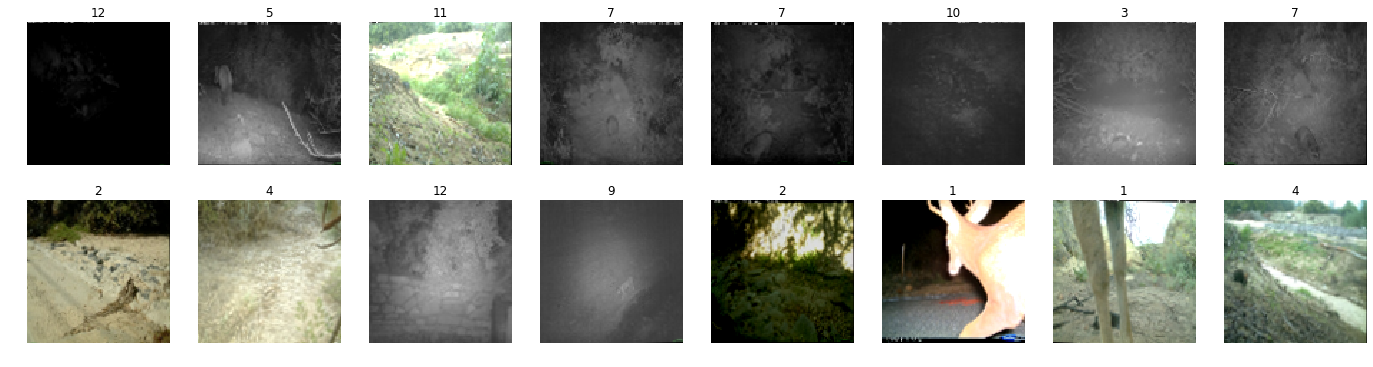

In [0]:
wild_data_split.resize(img_dims=(100,100,3), resize="stretch")
wild_data_split.show()

In [0]:
model_ds_os_aug = CNNLearner(name="xception_3", 
                    path=str(DATA_DIR), 
                    data=wild_data_split, 
                    base_model=keras.applications.Xception,
                    input_shape=(100,100,3), 
                    output_layer=keras.layers.Dense(
                        14,
                        kernel_regularizer=keras.regularizers.l1_l2(1e-7, 3e-4),
                        activation=keras.activations.softmax,
                    ), 
                    dropout=0.45, 
                    load="m2_downsampled_unfrozen_100")

model_ds_os_aug.compile(optimizer=keras.optimizers.Adam,
              lr=1e-4,
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

Note: m2_downsampled_unfrozen_100 are loaded.


In [0]:
model_ds_os_aug.freeze(3)
model_ds_os_aug.fit(1, lr=1e-4, name="m3_dsosaug_frozen_100")

All but 3 layers frozen. Compilation arguments not provided model recompiled with previous settings.
Train for 1716 steps, validate for 608 steps
1716/1716 [==============================] - 946s 551ms/step - loss: 1.3267 - sparse_categorical_accuracy: 0.5846 - val_loss: 0.4562 - val_sparse_categorical_accuracy: 0.8894
Note: m3_dsosaug_frozen_100 are loaded.


In [0]:
model_ds_os_aug.unfreeze()
model_ds_os_aug.fit_one_cycle(lr=(5e-5, 2e-4), name="m3_dsosaug_unfrozen_100",
                            epochs=4)

Note: Discriminative learning rates are disabled, but tuple lr is passed. Use dlr=True for DLR optimizer.
Train for 1716 steps, validate for 608 steps
Epoch 1/4
1716/1716 [==============================] - 943s 549ms/step - loss: 1.2000 - sparse_categorical_accuracy: 0.6131 - val_loss: 0.4463 - val_sparse_categorical_accuracy: 0.8893
Epoch 2/4
1716/1716 [==============================] - 945s 551ms/step - loss: 1.1939 - sparse_categorical_accuracy: 0.6107 - val_loss: 0.4429 - val_sparse_categorical_accuracy: 0.8913
Epoch 3/4
1716/1716 [==============================] - 949s 553ms/step - loss: 1.1792 - sparse_categorical_accuracy: 0.6191 - val_loss: 0.4473 - val_sparse_categorical_accuracy: 0.8881
Epoch 4/4
1716/1716 [==============================] - 945s 551ms/step - loss: 1.1601 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.4419 - val_sparse_categorical_accuracy: 0.8905
Note: m3_dsosaug_unfrozen_100 are loaded.


In [0]:
m3_dsosaug_f1 = model_ds_os_aug.acc_report()["macro avg"]["f1-score"]
print(f"------------------------------\nMODEL 1 BASELINE SCORE (UNWEIGHTED F1): {round(m1_baseline_f1, 5)}",
      f"\nMODEL 2 DOWNSAMPLED SCORE (UNWEIGHTED F1): {round(m2_downsampled_f1, 5)}",
      f"\nMODEL 3 DOWNSAMPLED + UPSAMPLED + AUG SCORE (UNWEIGHTED F1): {round(m3_dsosaug_f1, 5)}",
      "\n------------------------------")

------------------------------
MODEL 1 BASELINE SCORE (UNWEIGHTED F1): 0.10481 
MODEL 2 DOWNSAMPLED SCORE (UNWEIGHTED F1): 0.70438 
MODEL 3 DOWNSAMPLED + UPSAMPLED + AUG SCORE (UNWEIGHTED F1): 0.72124 
------------------------------


# 5. ADD CLASS WEIGHTS

One more way to address the class imbalance at training time is to adjust the loss function to account for it using class weights. Class weights basically multiply loss by alpha for under-represented cases - your model will get a much higher loss, if it classifies wrongly a class that has very few images (and will not get too much punished for getting the largest classes wrong). Class weights are implemented in Keras' model.fit function.

In [0]:
# Initiate the model, decrease regularization and load weights.
model_weights = CNNLearner(name="xception_4", 
                    path=str(DATA_DIR), 
                    data=wild_data_split, 
                    base_model=keras.applications.Xception,
                    input_shape=(100,100,3), 
                    output_layer=keras.layers.Dense(
                        14,
                        kernel_regularizer=keras.regularizers.l1_l2(1e-8, 1e-4),
                        activation=keras.activations.softmax,
                    ), 
                    dropout=0.39, 
                    load="m3_dsosaug_unfrozen_100")

model_weights.compile(optimizer=keras.optimizers.Adam,
              lr=1e-4,
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

Note: m3_dsosaug_unfrozen_100 are loaded.


In [0]:
# Redefine the augmentor
my_aug_2 = Augmentor(h_flip=0.5, v_flip=0, brightness=(0.5, 0.3),
                    contrast=(0.5,0.3), blur=(0.5, (0,0.05)), warp=0.025,
                   zoom=(0.0,0.0), pipeline=None)

wild_data_split.reaugment(my_aug_2)

In [0]:
model_weights.freeze(3)
model_weights.fit(1, lr=1e-4, name="m4_weights_frozen_100", class_weights=True)

All but 3 layers frozen. Compilation arguments not provided model recompiled with previous settings.
Train for 1716 steps, validate for 608 steps
1716/1716 [==============================] - 960s 559ms/step - loss: 1.2145 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.4489 - val_sparse_categorical_accuracy: 0.8884
Note: m4_weights_frozen_100 are loaded.


In [0]:
model_weights.unfreeze()
model_weights.fit_one_cycle(lr=(5e-5, 2e-4), name="m4_weights_unfrozen_100",
                            epochs=4, class_weights=True)

Note: Discriminative learning rates are disabled, but tuple lr is passed. Use dlr=True for DLR optimizer.
Train for 1716 steps, validate for 608 steps
Epoch 1/4
1716/1716 [==============================] - 807s 471ms/step - loss: 1.1009 - sparse_categorical_accuracy: 0.6420 - val_loss: 0.4365 - val_sparse_categorical_accuracy: 0.8891
Epoch 2/4
1716/1716 [==============================] - 796s 464ms/step - loss: 1.0911 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.4479 - val_sparse_categorical_accuracy: 0.8891
Epoch 3/4
1716/1716 [==============================] - 793s 462ms/step - loss: 1.0893 - sparse_categorical_accuracy: 0.6427 - val_loss: 0.4401 - val_sparse_categorical_accuracy: 0.8895
Epoch 4/4
1716/1716 [==============================] - 779s 454ms/step - loss: 1.0819 - sparse_categorical_accuracy: 0.6449 - val_loss: 0.4423 - val_sparse_categorical_accuracy: 0.8912
Note: m4_weights_unfrozen_100 are loaded.


In [15]:
m4_weights_f1 = model_weights.acc_report()["macro avg"]["f1-score"]
print(f"------------------------------\nMODEL 1 BASELINE SCORE (UNWEIGHTED F1): {round(m1_baseline_f1, 5)}",
      f"\nMODEL 2 DOWNSAMPLED SCORE (UNWEIGHTED F1): {round(m2_downsampled_f1, 5)}",
      f"\nMODEL 3 DOWNSAMPLED + UPSAMPLED + AUG SCORE (UNWEIGHTED F1): {round(m3_dsosaug_f1, 5)}",
      f"\nMODEL 4 DOWNSAMPLED + UPSAMPLED + AUG + CLASS WEIGHTS (UNWEIGHTED F1): {round(m3_dsosaug_f1, 5)}",
      "\n------------------------------")

------------------------------
MODEL 1 BASELINE SCORE (UNWEIGHTED F1): 0.10481 
MODEL 2 DOWNSAMPLED SCORE (UNWEIGHTED F1): 0.70438 
MODEL 3 DOWNSAMPLED + UPSAMPLED + AUG SCORE (UNWEIGHTED F1): 0.72124 
MODEL 4 DOWNSAMPLED + UPSAMPLED + AUG + CLASS WEIGHTS (UNWEIGHTED F1): 0.73145 
------------------------------


# 6. FINAL MODEL: M4 ON FULL DATASET (+ INCREASE IMG SIZE)

Model 4 seems to work fine, but it has already started to overfit, even though the training accuracy is still way below perfect. We have been using 1/3rd of the training data, so it is natural that the model is lacking diversity in the data. We will use model 4 with the full training set and then increase image size to feed he model more data.

**Final model**: downsampling + upsampling + augmentation + class weights + full "high-res" dataset

In [0]:
# Recreate the dataframe and split
wild_data_raw = DataRaw(DATA_DIR, filetype="jpg")
wild_data_raw.init_df(dataframe_path=DATA_DIR/"train.csv", label_col="category_id", 
                      id_col="file_name")
wild_data_raw.df.label = wild_data_raw.df.label.map(lambda x: str(x))
wild_data_raw.label_encode(label_map=label_map, one_hot=False)

# Define the augmentor
my_aug_3 = Augmentor(h_flip=0.5, v_flip=0, brightness=(0.5, 0.2),
                    contrast=(0.5,0.2), blur=(0.1, (0,0.25)), pipeline=None)

# Split the data, apply upsampling and augmentation
wild_data_split_final = DataSplit(wild_data_raw, 
                        val_test_size=(0.08,0.0), 
                        batch_size=16, 
                        train_shuffle=True, 
                        prefetch=1, 
                        num_parallel_calls=-1, 
                        aug=my_aug_3,
                      upsample=0.02)

In [0]:
# One image has invalid date value (11 11)
wild_data_split_final.train_dataframe.sort_values(by="date_captured").head(3)
wild_data_split_final.train_dataframe = wild_data_split_final.train_dataframe.drop(100372)

# Downsample "empty" categories from previous step
pd.set_option('mode.chained_assignment', None)
# Extract month of year and hour of day from date_captured

wild_data_split_final.train_dataframe.date_captured = (wild_data_split_final
                                                       .train_dataframe.date_captured.astype('datetime64[ns]'))
wild_data_split_final.train_dataframe["time_captured"] = (wild_data_split_final
                                                          .train_dataframe.date_captured.dt.hour)
wild_data_split_final.train_dataframe["month_captured"] = (wild_data_split_final
                                                           .train_dataframe.date_captured.dt.month)

# Create weights
sampling_df = wild_data_split_final.train_dataframe.loc[wild_data_split_final.train_dataframe.label == 0, :].copy()

# Group by month and time of the photo. Calculate counts for each group.
location_month_time_counts = sampling_df.groupby(["location", "month_captured",
                                        "time_captured"]).label.count().reset_index()
location_month_time_counts.columns = ["location", "month_captured", "time_captured", "count"]

# Get the total number of photos for each location/month.
location_month_counts = sampling_df.groupby(["location", "month_captured"]).label.count().reset_index()
location_month_counts.columns = ["location", "month_captured", "count_total"]

total_weight = pd.merge(location_month_time_counts, location_month_counts, on=["location", "month_captured"])
total_weight["total_N"] = len(sampling_df)


total_weight["weight"] = (1/total_weight["count"]) + (1/(total_weight["count_total"]/total_weight.total_N))

total_weight.weight = total_weight.weight + abs(min(total_weight.weight))

sampling_df = pd.merge(sampling_df, total_weight[["location", "month_captured", "time_captured", "weight"]],
                  on=["location", "month_captured", "time_captured"])

sampled_df = sampling_df.sample(frac=0.10, weights="weight", replace=False)

# Delete cases with label 0 in the train dataframe
wild_data_split_final.train_dataframe = wild_data_split_final.train_dataframe.loc[
    wild_data_split_final.train_dataframe.label != 0, :]
# Replace it with the newly downsampled cases
wild_data_split_final.train_dataframe = wild_data_split_final.train_dataframe.append(sampled_df)
# Reshuffle
wild_data_split_final.train_dataframe = wild_data_split_final.train_dataframe.sample(frac=1)

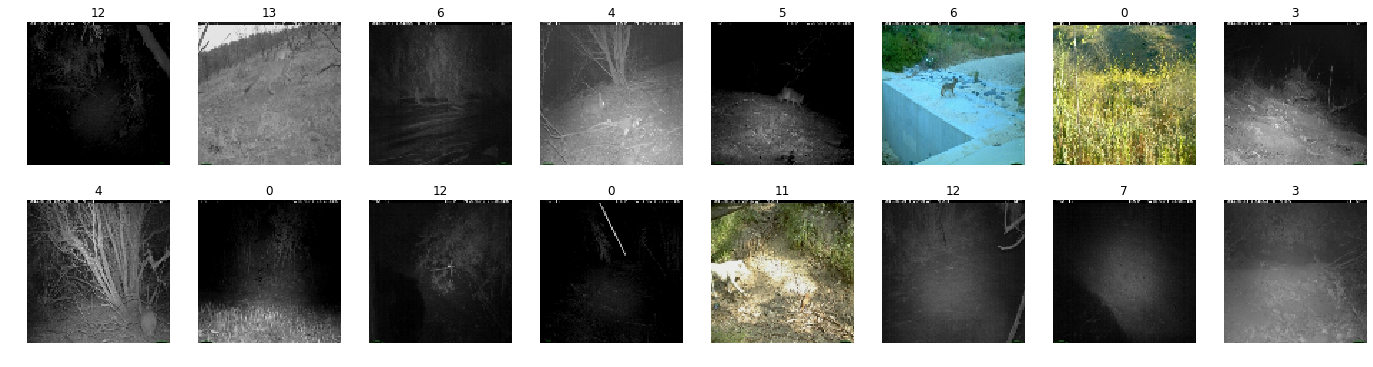

In [26]:
wild_data_split_final.resize(img_dims=(100,100,3), resize="stretch")
wild_data_split_final.show()

In [0]:
model_final = CNNLearner(name="xception_5", 
                    path=str(DATA_DIR), 
                    data=wild_data_split_final, 
                    base_model=keras.applications.Xception,
                    input_shape=(100,100,3), 
                    output_layer=keras.layers.Dense(
                        14,
                        kernel_regularizer=keras.regularizers.l1_l2(1e-8, 3e-5),
                        activation=keras.activations.softmax,
                    ), 
                    dropout=0.39, 
                    load="m4_weights_unfrozen_100")

model_final.compile(optimizer=keras.optimizers.Adam,
              lr=1e-4,
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [35]:
model_final.fit_one_cycle(lr=(5e-5, 2e-4), name="m5_final_unfrozen_100",
                            epochs=5, class_weights=True)

Note: Discriminative learning rates are disabled, but tuple lr is passed. Use dlr=True for DLR optimizer.
Train for 6378 steps, validate for 982 steps
Epoch 1/5
6378/6378 [==============================] - 1473s 231ms/step - loss: 0.8098 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.2742 - val_sparse_categorical_accuracy: 0.9225
Epoch 2/5
6378/6378 [==============================] - 1438s 226ms/step - loss: 0.5624 - sparse_categorical_accuracy: 0.8186 - val_loss: 0.2560 - val_sparse_categorical_accuracy: 0.9300
Epoch 3/5
6378/6378 [==============================] - 1407s 221ms/step - loss: 0.4620 - sparse_categorical_accuracy: 0.8487 - val_loss: 0.2008 - val_sparse_categorical_accuracy: 0.9400
Epoch 4/5
6378/6378 [==============================] - 1408s 221ms/step - loss: 0.3779 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.2133 - val_sparse_categorical_accuracy: 0.9390
Epoch 5/5
6378/6378 [==============================] - 1402s 220ms/step - loss: 0.3276 - sparse_categoric

In [41]:
m5_final_f1 = acc_report(model_final)["macro avg"]["f1-score"]
m5_final_f1

0.8639308592553286

In [29]:
wild_data_split_final.resize(img_dims=(260,260,3), resize="stretch")
model_final.recompile(input_shape=(260,260,3), load="m5_final_unfrozen_100")

Note: m5_final_frozen_260 are loaded.


In [13]:
model_final.freeze(3)
model_final.fit(1, lr=1e-4, name="m5_final_frozen_260", class_weights=True)

All but 3 layers frozen. Compilation arguments not provided model recompiled with previous settings.
Train for 6373 steps, validate for 982 steps
6373/6373 [==============================] - 2157s 338ms/step - loss: 1.5456 - sparse_categorical_accuracy: 0.4856 - val_loss: 1.8047 - val_sparse_categorical_accuracy: 0.2727
Note: m5_final_frozen_260 are loaded.


In [30]:
model_final.unfreeze()
model_final.fit_one_cycle(lr=(1e-5, 1e-4), name="m5_final_unfrozen_260",
                            epochs=4, class_weights=True)

Note: Discriminative learning rates are disabled, but tuple lr is passed. Use dlr=True for DLR optimizer.
Train for 6378 steps, validate for 981 steps
Epoch 1/4
6378/6378 [==============================] - 6211s 974ms/step - loss: 0.6526 - sparse_categorical_accuracy: 0.7869 - val_loss: 0.1604 - val_sparse_categorical_accuracy: 0.9503
Epoch 2/4
6378/6378 [==============================] - 6190s 971ms/step - loss: 0.3241 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.1321 - val_sparse_categorical_accuracy: 0.9592
Epoch 3/4
6378/6378 [==============================] - 6137s 962ms/step - loss: 0.2277 - sparse_categorical_accuracy: 0.9253 - val_loss: 0.1160 - val_sparse_categorical_accuracy: 0.9652
Epoch 4/4
 150/6378 [..............................] - ETA: 1:36:45 - loss: 0.2062 - sparse_categorical_accuracy: 0.9299WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: ignored

In [31]:
m5_final_f1 = model_final.acc_report()["macro avg"]["f1-score"]
print(f"------------------------------\nMODEL 1 BASELINE SCORE (UNWEIGHTED F1): {round(m1_baseline_f1, 5)}",
      f"\nMODEL 2 DOWNSAMPLED SCORE (UNWEIGHTED F1): {round(m2_downsampled_f1, 5)}",
      f"\nMODEL 3 DOWNSAMPLED + UPSAMPLED + AUG SCORE (UNWEIGHTED F1): {round(m3_dsosaug_f1, 5)}",
      f"\nMODEL 4 DOWNSAMPLED + UPSAMPLED + AUG + CLASS WEIGHTS (UNWEIGHTED F1): {round(m4_weights_f1, 5)}",
      f"\nMODEL 5 FINAL: M4 + FULL SIZE SET/IMAGES (UNWEIGHTED F1): {round(m5_final_f1, 5)}",
      "\n------------------------------")

------------------------------
MODEL 1 BASELINE SCORE (UNWEIGHTED F1): 0.10481 
MODEL 2 DOWNSAMPLED SCORE (UNWEIGHTED F1): 0.70438 
MODEL 3 DOWNSAMPLED + UPSAMPLED + AUG SCORE (UNWEIGHTED F1): 0.72124 
MODEL 4 DOWNSAMPLED + UPSAMPLED + AUG + CLASS WEIGHTS (UNWEIGHTED F1): 0.73145 
MODEL 5 FINAL: M4 + FULL SIZE SET/IMAGES (UNWEIGHTED F1): 0.91995 
------------------------------


# TEST TIME!

In [0]:
# Unzip test image id csv
!unzip -q test.csv -d {DATA_DIR}

In [0]:
# Read the csv, tidy up the file paths and replace the test dataframe of our split
test_csv = pd.read_csv(DATA_DIR/"test.csv")

test_csv["id"] = test_csv["id"].map(lambda x: str(DATA_DIR/"test") + "/" + x + ".jpg")
test_csv["label"] = 0
test_csv = test_csv.loc[:, ["id", "label"]]

wild_data_split_final.test_dataframe = test_csv

In [0]:
# Remap the image resizer to the new test data
wild_data_split_final.resize(img_dims=(260,260,3), resize="stretch")

In [0]:
# Make predictions
preds = model_final.model.predict(wild_data_split_final.test, 
                                  steps=len(wild_data_split_final.test_dataframe)//16) + 1

preds_argmax = preds.argmax(axis=1)
test_csv["Predictions"] = preds_argmax[:len(test_csv)]
test_csv.columns = ["Id", "label", "Predicted"]
test_csv = test_csv[["Id", "Predicted"]]
test_csv["Id"] = test_csv.Id.str.extract(".*/(.*).jpg")
test_csv.to_csv(DATA_DIR/"predictions.csv", index=False)

![Score text](https://i.ibb.co/x21Dwy5/score.png)
![Leaderboard](https://i.ibb.co/GMt374w/leaderboard.png)

# TO DOs (experiments to improve results)
- Final round of training - 100% train/0% validation/no augmentation (1 epoch)
- Use additional data to get all the classes (currently 14/22) https://github.com/visipedia/iwildcam_comp
- Use larger image sizes, as that seems to work very well
- Use location-based train/validation splits to ensure better generalization (e.g. train on images taken in locations 1-50, validate on 51-60)
- Try out different architectures (Resnet/Efficientnet) and blend results with the Xception model
- Use a two-step model: 1) detect whether there's an animal in the image (binary classifier + bounding box), crop the area with animal and move the cropped image to the second model that classifies classes.
- Use contrast/whiteness correction based (especially for images taken at night, as those seem to be of much poorer quality)